In [139]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from hep_ml import reweight
from hep_ml.metrics_utils import ks_2samp_weighted
from sklearn.model_selection import train_test_split

In [147]:
#Ensure 

# B_SmallestDeltaChi2OneTrack
# B_FD_OWNPV
# Kplus_PT
# piminus_PT
# Kst_892_0_IP_OWNPV


sharedColums = ["nTracks","B_P", "B_Cone3_B_ptasy", "B_ETA" ]

columns    = {"kpi"  : sharedColums + ["Kst_892_0_PT"] ,
              "pipi" : sharedColums + ["rho_770_0_PT"]}

plotingColums = columns["kpi"] + ["B_SmallestDeltaChi2OneTrack","B_FD_OWNPV","Kplus_PT","piminus_PT","Kst_892_0_IP_OWNPV","B_Cone3_B_ptasy"]


modes      = ["kpi","kpisw", "pipi"]
hist_style = {"bins" : 50, "density" : True, "alpha" : 1, "histtype" : "step"}
colors     = {"kpi" : "#066bd6", "kpisw"  : "#d60645",  "pipi" : "#2fad66", "rw":"#2fad66","ratio":"#000000"}

In [148]:
dataframes  = {}
path = "/Users/finnjohnonori/Documents/GitHubRepositories/MScProject/data/"

# Imports the Kpi monte carlo data - Original
with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as Kpi_TChain_MC_up: # type: ignore
    Kpi_TTree_up         = Kpi_TChain_MC_up["DecayTree"]
    Kpi_up_MC_df         = Kpi_TTree_up.arrays(columns["kpi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as Kpi_TChain_MC_down: # type: ignore
    Kpi_TTree_MC_down    = Kpi_TChain_MC_down["DecayTree"]
    Kpi_down_MC_df       = Kpi_TTree_MC_down.arrays(columns["kpi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

dataframes["kpi"]   = pd.concat((Kpi_up_MC_df, Kpi_down_MC_df))

#Import the pipi monte carlo data
with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as pipi_TChain_MC_up: # type: ignore
    pipi_TTree_MC_up     = pipi_TChain_MC_up["DecayTree"]
    pipi_up_MC_df        = pipi_TTree_MC_up.arrays(columns["pipi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as pipi_TChain_MC_down: # type: ignore
    pipi_TTree_MC_down   = pipi_TChain_MC_down["DecayTree"]
    pipi_down_MC_df      = pipi_TTree_MC_down.arrays(columns["pipi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

dataframes["pipi"]  = pd.concat((pipi_up_MC_df, pipi_down_MC_df))

#Imports the Sample Data - Target
with uproot.open(path + "Sample_Kpigamma_2018_selectedTree_with_sWeights_Analysis_2hg_Unbinned-Mask1.root") as Kpi_TChain_SM: # type: ignore
    Kpi_TTree_SM         = Kpi_TChain_SM["DecayTree"]

dataframes["kpisw"] = Kpi_TTree_SM.arrays(columns["kpi"] + ["NB0_Kpigamma_sw"], library="pd", cut = "(abs(B_M01-895.55)<100)", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore
dataframes["kpisw"] = dataframes["kpisw"].reset_index(drop=True)

print("Data has been loaded")

Data has been loaded


In [142]:
# divide original samples into training ant test parts
kpiMC_train, kpiMC_test = train_test_split(dataframes["kpi"])
# divide target samples into training ant test parts
kpiSW_train, kpiSW_test = train_test_split(dataframes["kpisw"])

kpiMC_weights_train  = np.ones(len(kpiMC_train))
kpiMC_weights_test   = np.ones(len(kpiMC_test))

kpiSW_weights_train  = kpiSW_train["NB0_Kpigamma_sw"]
kpiSW_weights_test   = kpiSW_test["NB0_Kpigamma_sw"]
print("Data has been Split")

Data has been Split


In [143]:
StandardReweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
StandardReweighter.fit(kpiMC_train, kpiSW_train[columns["kpi"]], original_weight=kpiMC_weights_train , target_weight=kpiSW_weights_train)
print("Standard Reweighter Created")

Standard Reweighter Created


In [144]:
GradientBoostedReweighter_base = reweight.GBReweighter(n_estimators=50,  learning_rate=0.1, max_depth=3, min_samples_leaf=1000, gb_args={'subsample': 0.4})
GradientBoostedReweighter      = reweight.FoldingReweighter(GradientBoostedReweighter_base, n_folds=2)

GradientBoostedReweighter.fit(kpiMC_train, kpiSW_train[columns["kpi"]])

FoldingReweighter(base_reweighter=GBReweighter(gb_args={'subsample': 0.4},
                                               learning_rate=0.1,
                                               min_samples_leaf=1000,
                                               n_estimators=50))

In [145]:

def CreateDoublePlot(variable, Reweighter):

    #Create First Two Plots
    canvas, (disti,ratio) = plt.subplots(2,1, gridspec_kw={"height_ratios" : [2,1] },figsize=(8, 7))
    canvas.tight_layout()

    ratio.grid(axis="both", linestyle="dashed", alpha=0.5)
    disti.grid(axis="both", linestyle="dashed", alpha=0.5)

    KS_before = ks_2samp_weighted(kpiMC_test[variable], kpiSW_test[variable], weights1=kpiMC_weights_test, weights2=np.ones(len(kpiSW_test[variable]), dtype=float))

    xLowerBound = min(list(kpiMC_test[variable]) + list(kpiSW_test[variable]))
    xUpperBound = max(list(kpiMC_test[variable]) + list(kpiSW_test[variable]))
    hist_kpi_y,   hist_kpi_x,   _  = disti.hist(kpiMC_test[variable], range=(xLowerBound, xUpperBound), color=colors["kpi"],  label="kpi MC",     **hist_style)
    hist_kpisw_y, hist_kpisw_x, _  = disti.hist(kpiSW_test[variable], range=(xLowerBound, xUpperBound), color=colors["kpisw"], label="Kpi Sample", **hist_style)
    
    ratio.set_yscale("log")

    ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=-1, posinf=-1, neginf=-1)
    ratio.scatter(hist_kpisw_x[:-1], ratio_data, c=colors["kpi"], s=5)

    FittedWeights = Reweighter.predict_weights(kpiMC_test)
    KS_After = ks_2samp_weighted(kpiMC_test[variable], kpiSW_test[variable], weights1=FittedWeights, weights2=np.ones(len(kpiSW_test[variable]), dtype=float))


    ydistUpperBound = max(list(hist_kpisw_y) + list(hist_kpi_y) + list(hist_trained_kpi_y) + list(hist_kpisw_y) )*1.1

    ratio_data_trained = np.nan_to_num( (hist_kpisw_y / hist_trained_kpi_y), nan=-1, posinf=-1, neginf=-1)

    ratio.scatter(hist_kpisw_x[:-1],ratio_data_trained, c=colors["pipi"], s=5)

    disti.set_ylim(0, ydistUpperBound)
    ratio.set_xlim(xLowerBound, xUpperBound)
    disti.set_xlim(xLowerBound, xUpperBound)
    
    disti.xaxis.set_tick_params(which = "both",labelbottom=False, bottom=False)
    disti.legend()
    disti.set_title(f"{variable}   KSR: {np.round(KS_before - KS_After,4)}")

    plt.savefig(f"../imgs/{variable}_Reweight.png")
    return (KS_before - KS_After)

/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_8410/227062906.py:19: RuntimeWarning: divide by zero encountered in divide
  ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_8410/227062906.py:28: RuntimeWarning: divide by zero encountered in divide
  ratio_data_trained = np.nan_to_num( (hist_kpisw_y / hist_trained_kpi_y), nan=-1, posinf=-1, neginf=-1)


KFold prediction using random reweighter (length of data passed not equal to length of train)


/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_8410/227062906.py:19: RuntimeWarning: invalid value encountered in divide
  ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_8410/227062906.py:28: RuntimeWarning: invalid value encountered in divide
  ratio_data_trained = np.nan_to_num( (hist_kpisw_y / hist_trained_kpi_y), nan=-1, posinf=-1, neginf=-1)


KFold prediction using random reweighter (length of data passed not equal to length of train)
KFold prediction using random reweighter (length of data passed not equal to length of train)
KFold prediction using random reweighter (length of data passed not equal to length of train)
KFold prediction using random reweighter (length of data passed not equal to length of train)
Total KSR 0.7233128532397154


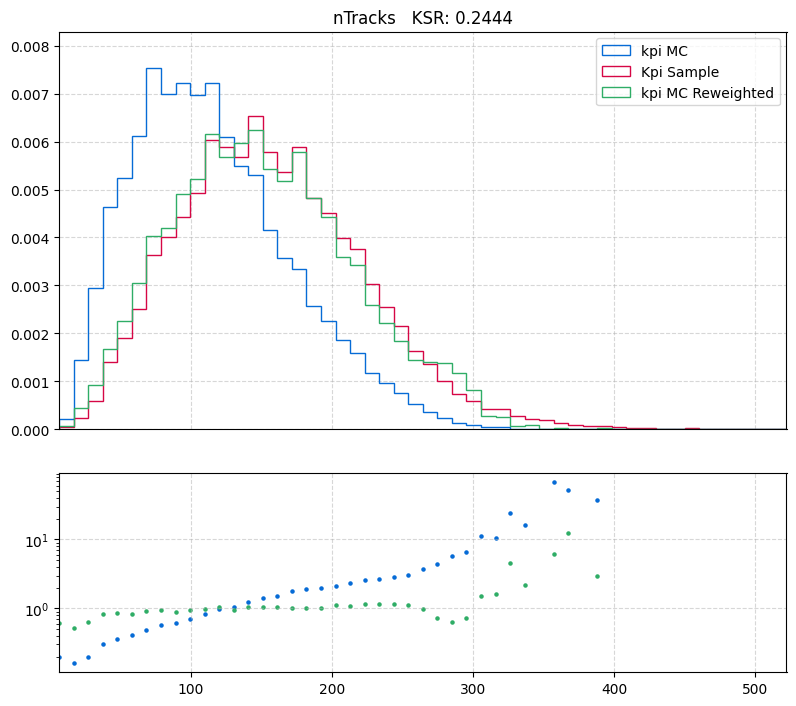

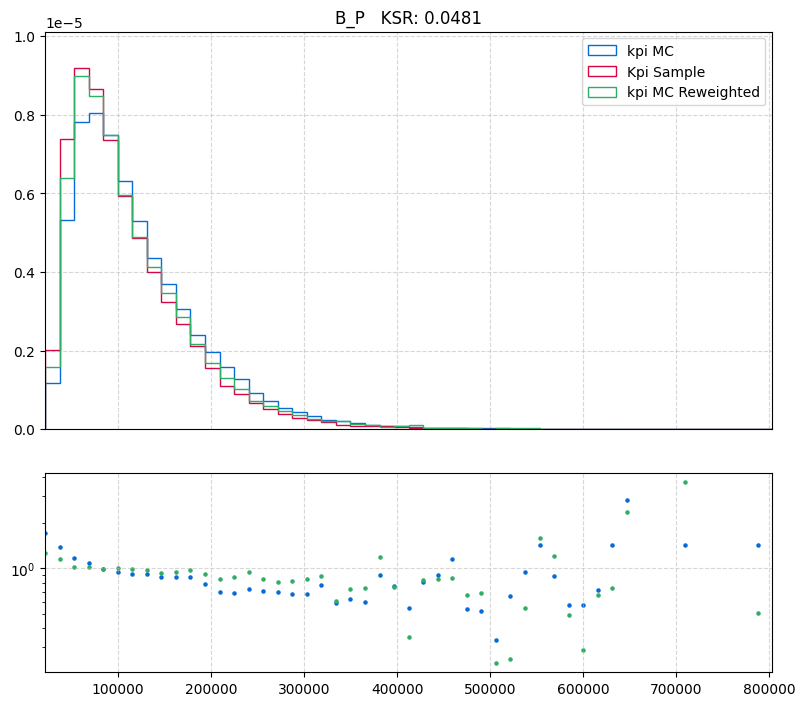

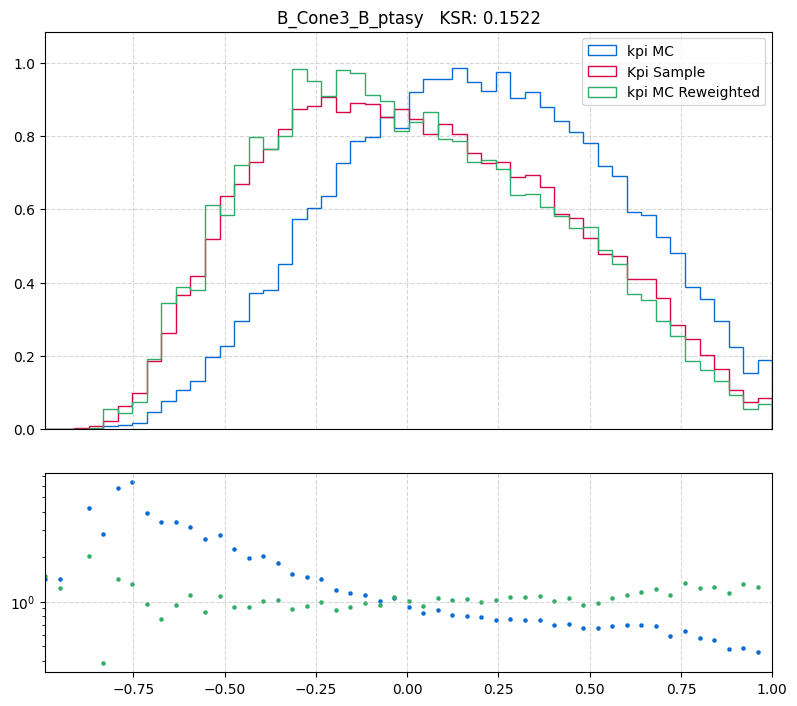

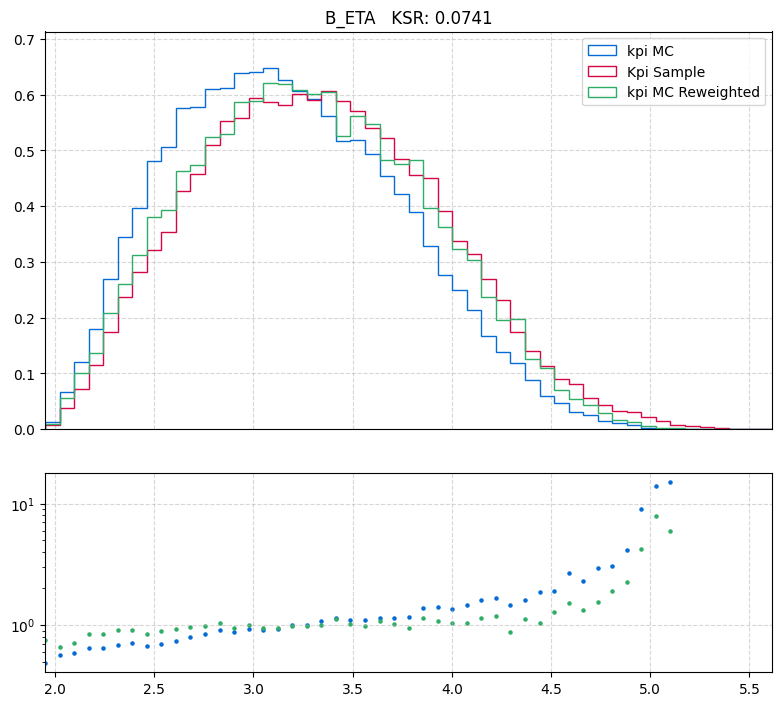

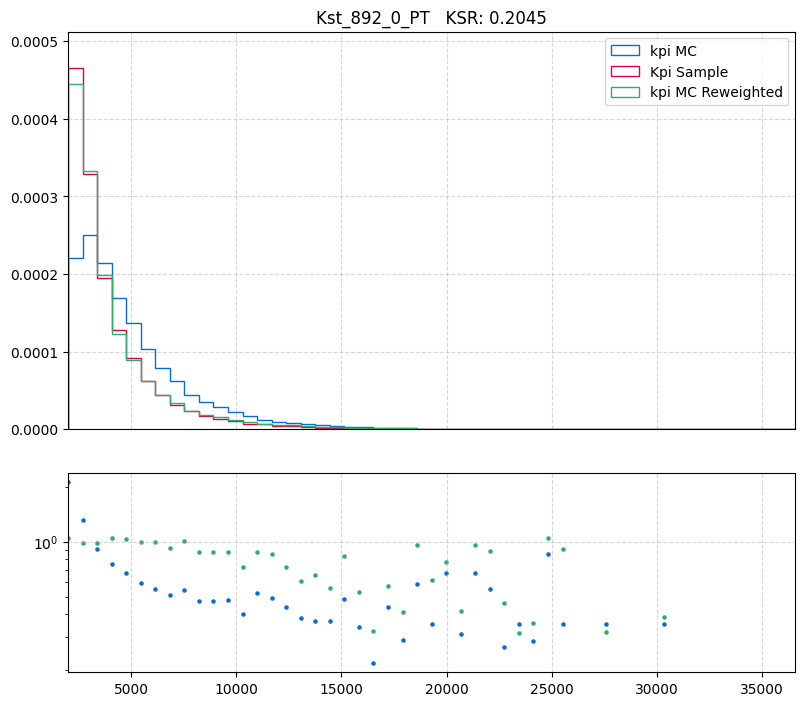

In [146]:
total_KS = 0

for var in columns["kpi"]:
    KS_Residual = CreateDoublePlot(variable=var, Reweighter=GradientBoostedReweighter)
    total_KS += KS_Residual


print("Total KSR", total_KS)

#0.8350859040429011